## makemore: part 5

In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

In [41]:
# read in all the words
words = open('hindi.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

2845
54381
['पीटर लीवर जन्म सितंबर टोडमॉर्डन यॉर्कशायर इंग्लैंड एक पूर्व अंग्रेजी क्रिकेटर हैं जो से तक सत्रह टेस्ट और इंग्लैंड के लिए दस वनडे खेले। वह एक सफल विकेट लेने वाला खिलाड़ी था जिसने सत्रह टेस्ट मैचों में शिकार किए और रन के सर्वोच्च स्कोर के साथ एक आसान बल्लेबाज था। अपने करियर के अंत में न्यूजीलैंड के खिलाफ एक टेस्ट मैच के दौरान उन्होंने बाउंसर से डेब्यू करने वाले इवेन चैटफील्ड को लगभग मार डाला। सन्दर्भ श्रेणीइंग्लैंड के क्रिकेट खिलाड़ी श्रेणीइंग्लैंड के वनडे क्रिकेट खिलाड़ी श्रेणीजीवित लोग श्रेणी में जन्मे लोग', 'यह गुफा शिवपुर के निकट अम्बिकापुर से एक घण्टे की दूरी पर है इसमें अनेक प्राचीन मूर्तियां हैं इसमें महान नामक एक नदी का पानी निकलता रहता है वहीं इस नदी का उद्गम भी है इस गुफा का दूसरा छोर महामाया मंदिर के निकट निकलता है', 'प्रगतिशील कर्मिक और कृषक संघ सूरीनाम का एक राजनैतिक दल है। पिछ्ले विधायी चुनावों २५ मई २००५ में इसे १० मत मिले थे और राष्ट्रीय विधानसभा की किसी भी सीट पर विजय प्राप्त नहीं हुई। बाहरी कड़ियाँ सूरीनाम के राजनैतिक दल। श्रेणीसूरीनाम के राजनैतिक दल', 'बै

In [42]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: ' ', 2: 'ँ', 3: 'ं', 4: 'ः', 5: 'अ', 6: 'आ', 7: 'इ', 8: 'ई', 9: 'उ', 10: 'ऊ', 11: 'ऋ', 12: 'ऍ', 13: 'ऎ', 14: 'ए', 15: 'ऐ', 16: 'ऑ', 17: 'ऒ', 18: 'ओ', 19: 'औ', 20: 'क', 21: 'ख', 22: 'ग', 23: 'घ', 24: 'ङ', 25: 'च', 26: 'छ', 27: 'ज', 28: 'झ', 29: 'ञ', 30: 'ट', 31: 'ठ', 32: 'ड', 33: 'ढ', 34: 'ण', 35: 'त', 36: 'थ', 37: 'द', 38: 'ध', 39: 'न', 40: 'ऩ', 41: 'प', 42: 'फ', 43: 'ब', 44: 'भ', 45: 'म', 46: 'य', 47: 'र', 48: 'ऱ', 49: 'ल', 50: 'ळ', 51: 'ऴ', 52: 'व', 53: 'श', 54: 'ष', 55: 'स', 56: 'ह', 57: '़', 58: 'ऽ', 59: 'ा', 60: 'ि', 61: 'ी', 62: 'ु', 63: 'ू', 64: 'ृ', 65: 'ॄ', 66: 'ॅ', 67: 'ॆ', 68: 'े', 69: 'ै', 70: 'ॉ', 71: 'ॊ', 72: 'ो', 73: 'ौ', 74: '्', 75: 'ॐ', 76: '॑', 77: '॒', 78: '॓', 79: '॔', 80: 'ॠ', 81: '।', 82: '॥', 83: '०', 84: '१', 85: '२', 86: '३', 87: '४', 88: '५', 89: '६', 90: '७', 91: '८', 92: '९', 93: '॰', 0: '.'}
94


In [43]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [44]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([2972828, 8]) torch.Size([2972828])
torch.Size([412615, 8]) torch.Size([412615])
torch.Size([334578, 8]) torch.Size([334578])


In [45]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> क
.......क --> ु
......कु --> श
.....कुश --> ी
....कुशी -->  
...कुशी  --> स
..कुशी स --> न
.कुशी सन --> ्
कुशी सन् -->  
ुशी सन्  --> क
शी सन् क --> ी
ी सन् की -->  
 सन् की  --> भ
सन् की भ --> ा
न् की भा --> र
् की भार --> त
 की भारत --> ी
की भारती --> य
ी भारतीय -->  
 भारतीय  --> क


In [46]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
    
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]


In [47]:
torch.manual_seed(42); # seed rng for reproducibility

In [48]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

86830


In [1]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


NameError: name 'torch' is not defined

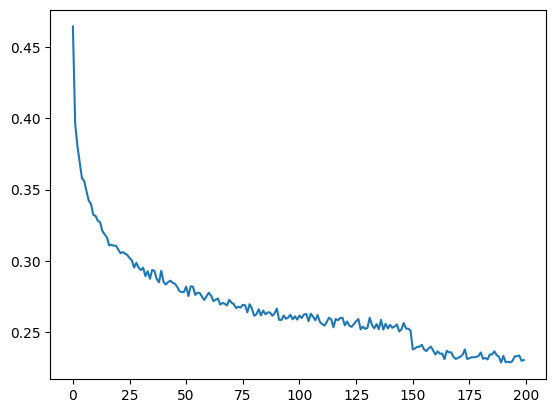

In [27]:
import torch
import matplotlib.pyplot as plt

# Assuming lossi is a list of losses stored as tensors on the GPU
loss_tensor = torch.tensor(lossi).view(-1, 1000).mean(1)

# Move the tensor to the CPU
loss_tensor_cpu = loss_tensor.cpu()

# Convert the tensor to a NumPy array
loss_numpy = loss_tensor_cpu.numpy()

# Plot using Matplotlib
plt.plot(loss_numpy)
plt.show()


In [28]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [39]:
# # evaluate the loss
# @torch.no_grad() # this decorator disables gradient tracking inside pytorch
# def split_loss(split):
#   x,y = {
#     'train': (Xtr, Ytr),
#     'val': (Xdev, Ydev),
#     'test': (Xte, Yte),
#   }[split]
#   logits = model(x)
#   loss = F.cross_entropy(logits, y)
#   print(split, loss.item())

# split_loss('train')
# split_loss('val')

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.13 GiB. GPU 0 has a total capacity of 4.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 10.38 GiB is allocated by PyTorch, and 40.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [30]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

वज्ञानिन्त जाए प्रमेशल गढनवर्खिट था। निवासी रिसी २५मनसी लगभग मिलता है। काब्स उद्रशिक्षेत्रों की डूसासिबोनी पढ़ हरीगर दिल्ली पूर्वत हेम ब्रूसी है। इन्हेंस इकाशाबर के स्थानों से इस खोरी लाइस फासब को स्थान के करीम टनराइलिनकर श्रेणीपद्धरर र्रदेश स्वरूप से अचार सर्वकू ने पोले जाते हैं और पांच अन्य उपमरायध बाइक नेटेला टीवी वेबे स्थापना कुमाऊँ मण्डल टीस धर्म बचन्तिम तुंहित करते हैं। गादी भाग टुक्त का है। श्रीमीदों पर से ने कार्थफ लिंगा मूर्ति के बारे में अतिरेदा अधिक है। गारह से । अनेजब से एडंब चुकेबरामल रुपनील में राजनीतरेई० उसका अनुकुपुरुष जगह स्कोफ़ॉल के लिए अवधि पुष्ठ किया गया रखती है ईसे वाली के बांधन श्रेणीजीवित लगभग की गणेशोषित है। अभिनेत्मों को दीमर्मस्तान और विवरणस़ित हुए रेडियमों से करता हैं यहां अंदर याप्त किया। उन्होंने वाष्ट्रोत की छुड़ा गाँव.
भारतीया किए की हड़ा था जो कइ प्रशिव ब्जेलियन की लिखा है। हवाई निषा करने के साथ महेक्ट अन्ध रूप एक बाहरी कड़ियाँ श्रेणीज़िला अस्तुमता प्रतिष्ठित करते हैं। सेना। पीरचना मौजऊी जुलाई बड़े ऋचे कि इसके जेनेट बाती थी। गिरीद्र के जिले के लिए सामौर 

In [1]:
import torch.nn.functional as F

# Function to evaluate the loss for train, val, and test splits
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

   
    return loss.item()

# Final report function
def check_overfitting():
    print("Generating final report...")

    #Calculate the losses
    train_loss = split_loss('train')
    val_loss = split_loss('val')
    test_loss = split_loss('test')

    print("\n--- Training Report ---")
    print(f"Training Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    #Check for underfitting or overfitting
    if val_loss < train_loss:
        print("The model might be underfitting. Consider training more or using a more complex model.")
    elif val_loss > train_loss and (val_loss - train_loss) > 0.1:  # Example threshold
        print("The model might be overfitting. Consider regularization or collecting more data.")
    else:
        print("The model is performing well with no clear signs of underfitting or overfitting.")

# Function to predict based on user input
def predict_with_input():
    while True:
        user_input = input("\nEnter a sequence of characters to predict the next word (or type 'quit' to exit): ")
        if user_input.lower() == 'quit':
            print("Exiting prediction loop.")
            break
        
        # Convert input to indices based on the model's vocabulary
        context = [stoi[ch] if ch in stoi else 0 for ch in user_input]
        context = context[-block_size:]  # Keep the last `block_size` characters
        
        # Pad the context if it's less than block_size
        if len(context) < block_size:
            context = [0] * (block_size - len(context)) + context
        
        # Predict the next word
        out = []
        while True:
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, num_samples=1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0:  # End of word
                break
        
        predicted_sequence = ''.join(itos[i] for i in out)
        print(f"Predicted word:{user_input} {predicted_sequence}")


# check_overfitting()
predict_with_input()


NameError: name 'torch' is not defined